In [1]:
path_to_fullres_img = "/storage/research/dbmr_luisierlab/database/Ovarian_Visium_GTOP/Visium_HD/HE_high_res_NAB-HUG-03/NAB-HUG-03_HE_Visium3_Scan1.qptiff"

# Read QPTIFF image using OpenSlide
import openslide

# Open the whole slide image
slide = openslide.OpenSlide(path_to_fullres_img)

# Get basic properties
print(f"Image dimensions (level 0): {slide.dimensions}")
print(f"Number of levels: {slide.level_count}")
print(f"Level dimensions: {slide.level_dimensions}")
print(f"Level downsamples: {slide.level_downsamples}")

# Get a thumbnail for quick visualization
thumbnail = slide.get_thumbnail(slide.dimensions)

# Or read a specific region at full resolution
# region = slide.read_region((x, y), level, (width, height))



Image dimensions (level 0): (30720, 38880)
Number of levels: 5
Level dimensions: ((30720, 38880), (15360, 19440), (7680, 9720), (3840, 4860), (1920, 2430))
Level downsamples: (1.0, 2.0, 4.0, 8.0, 16.0)


In [2]:
# Get the slide resolution
print("All properties:")
for key in sorted(slide.properties.keys()):
    if 'resolution' in key.lower() or 'mpp' in key.lower():
        print(f"{key}: {slide.properties[key]}")

# Get resolution from TIFF properties
y_resolution = float(slide.properties.get('tiff.YResolution', 0))
x_resolution = float(slide.properties.get('tiff.XResolution', 0))

print(f"\nX Resolution: {x_resolution} pixels/cm")
print(f"Y Resolution: {y_resolution} pixels/cm")

# Convert to microns per pixel
# Resolution is in pixels/cm, so we need: cm/pixel * 10000 microns/cm
microns_per_pixel_x = 10000 / x_resolution if x_resolution > 0 else None
microns_per_pixel_y = 10000 / y_resolution if y_resolution > 0 else None

print(f"\nMicrons per pixel (X): {microns_per_pixel_x:.4f} µm/pixel")
print(f"Microns per pixel (Y): {microns_per_pixel_y:.4f} µm/pixel")

All properties:
tiff.ResolutionUnit: centimeter
tiff.XResolution: 40126.380797114987
tiff.YResolution: 40126.380797114987

X Resolution: 40126.38079711499 pixels/cm
Y Resolution: 40126.38079711499 pixels/cm

Microns per pixel (X): 0.2492 µm/pixel
Microns per pixel (Y): 0.2492 µm/pixel


In [3]:
import anndata as ad

In [4]:
emb = ad.read_h5ad("D1_NAB_HUG_03_adata_016um_coding_with_positions.h5ad")

/storage/homefs/lf25x455/.conda/envs/digitalhisto/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/storage/homefs/lf25x455/.conda/envs/digitalhisto/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
spot_dim = 16 / microns_per_pixel_x

In [6]:
spot_dim

64.20220927538398

In [ ]:
# sub_obs = emb.obs[(emb.obs["pxl_row_in_fullres"] > 7000) & (emb.obs["pxl_row_in_fullres"] < 12500) & (emb.obs["pxl_col_in_fullres"] > 6000) & (emb.obs["pxl_col_in_fullres"] < 14000)]
# sub_emb = emb[sub_obs.index].copy()



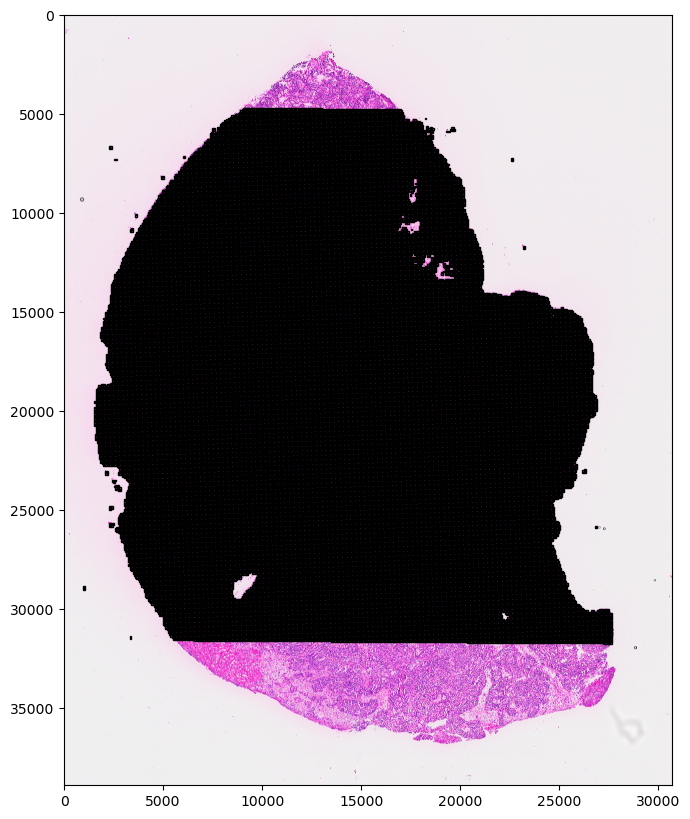

In [8]:
# visualize slide and pixel (8063.679882, 14696.827234)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(thumbnail)
# Add more visualization code as needed
#create a square with coordinates 8063.679882, 14696.827234 and length spot_dim
for idx, row in emb.obs.iterrows():
    x = row['pxl_col_in_fullres']
    y = row['pxl_row_in_fullres']
    rect = plt.Rectangle((x+spot_dim/2, y+spot_dim/2), spot_dim, spot_dim, edgecolor='black', facecolor='none')
    ax.add_patch(rect)
# rect = plt.Rectangle((8063.679882, 14696.827234), spot_dim, spot_dim, edgecolor='black', facecolor='none')
# ax.add_patch(rect)


In [9]:
emb.var_names.get_loc('SPP1')

4684

Text(0.5, 1.0, 'Spots with ACTB detected')

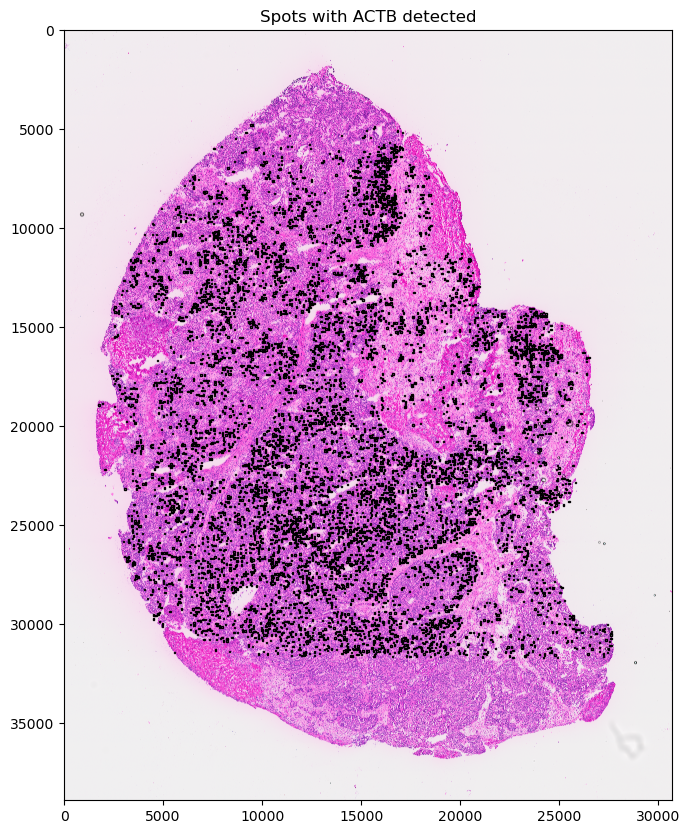

In [10]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(thumbnail)
# Add more visualization code as needed
i = 0
for idx, row in emb.obs.iterrows():
    if emb.X[i, emb.var_names.get_loc('ACTB')] > 1:
        x = row['pxl_col_in_fullres']
        y = row['pxl_row_in_fullres']
        rect = plt.Rectangle((x+spot_dim/2, y+spot_dim/2), spot_dim, spot_dim, edgecolor='black', facecolor='none')
        ax.add_patch(rect)
    i += 1
# rect = plt.Rectangle((8063.679882, 14696.827234), spot_dim, spot_dim, edgecolor='black', facecolor='none')
# ax.add_patch(rect)
plt.title("Spots with ACTB detected")

/tmp/ipykernel_132446/1217465019.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('summer')  # You can change to 'plasma', 'inferno', 'magma', etc.


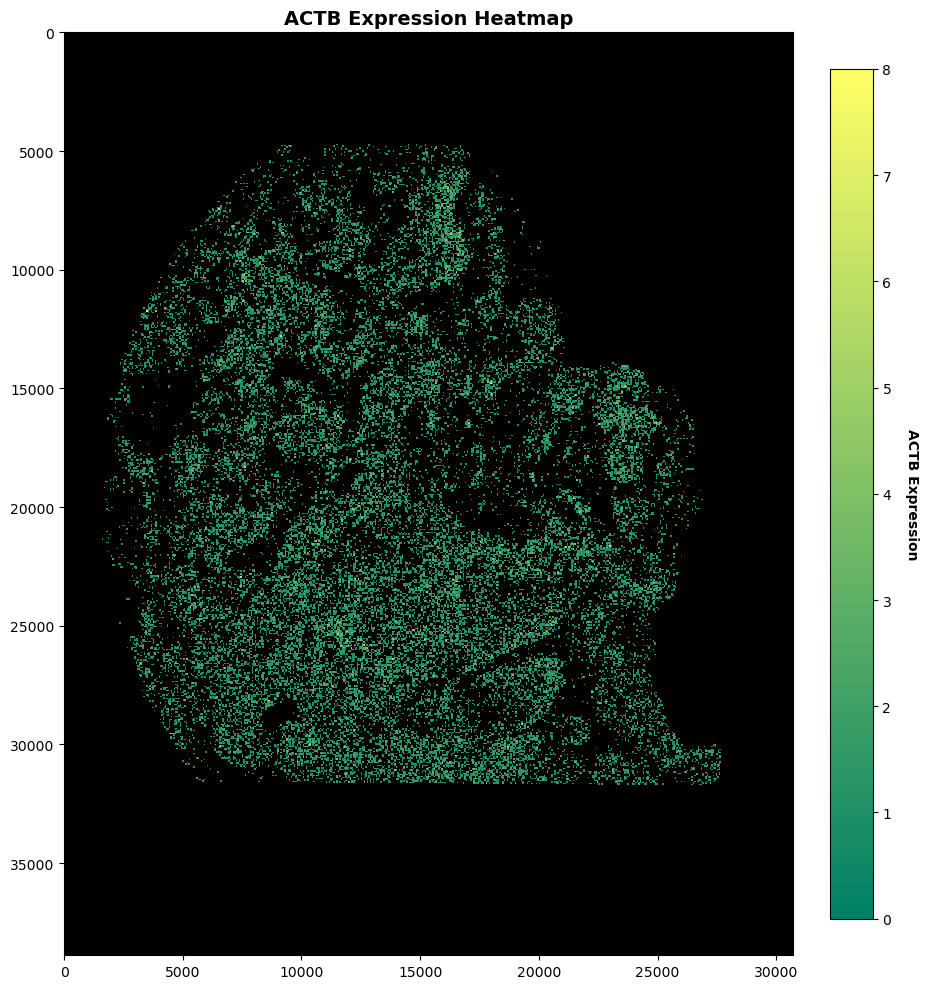

In [7]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np

# Get ACTB expression values
gene_idx = emb.var_names.get_loc('ACTB')
expression_values = np.array(emb.X[:, gene_idx].todense()).flatten()

# Create colormap normalization
vmin = expression_values.min()
vmax = expression_values.max()
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.get_cmap('summer')  # You can change to 'plasma', 'inferno', 'magma', etc.

# Create figure
fig, ax = plt.subplots(figsize=(10, 10))
black_image = np.zeros((thumbnail.size[1], thumbnail.size[0], 3), dtype=np.uint8)
ax.imshow(black_image)

# Plot spots with color representing expression
for i, (idx, row) in enumerate(emb.obs.iterrows()):
    expr_value = expression_values[i]
    if expr_value > 0:  # Only show spots with expression
        x = row['pxl_col_in_fullres']
        y = row['pxl_row_in_fullres']
        color = cmap(norm(expr_value))
        rect = plt.Rectangle((x+spot_dim/2, y+spot_dim/2), spot_dim, spot_dim, 
                            edgecolor='none', facecolor=color, alpha=1)
        ax.add_patch(rect)

# Add colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('ACTB Expression', rotation=270, labelpad=20, fontweight='bold')

plt.title("ACTB Expression Heatmap", fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

In [1]:
emb

NameError: name 'emb' is not defined

/tmp/ipykernel_132446/2800113154.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('summer')  # You can change to 'plasma', 'inferno', 'magma', etc.


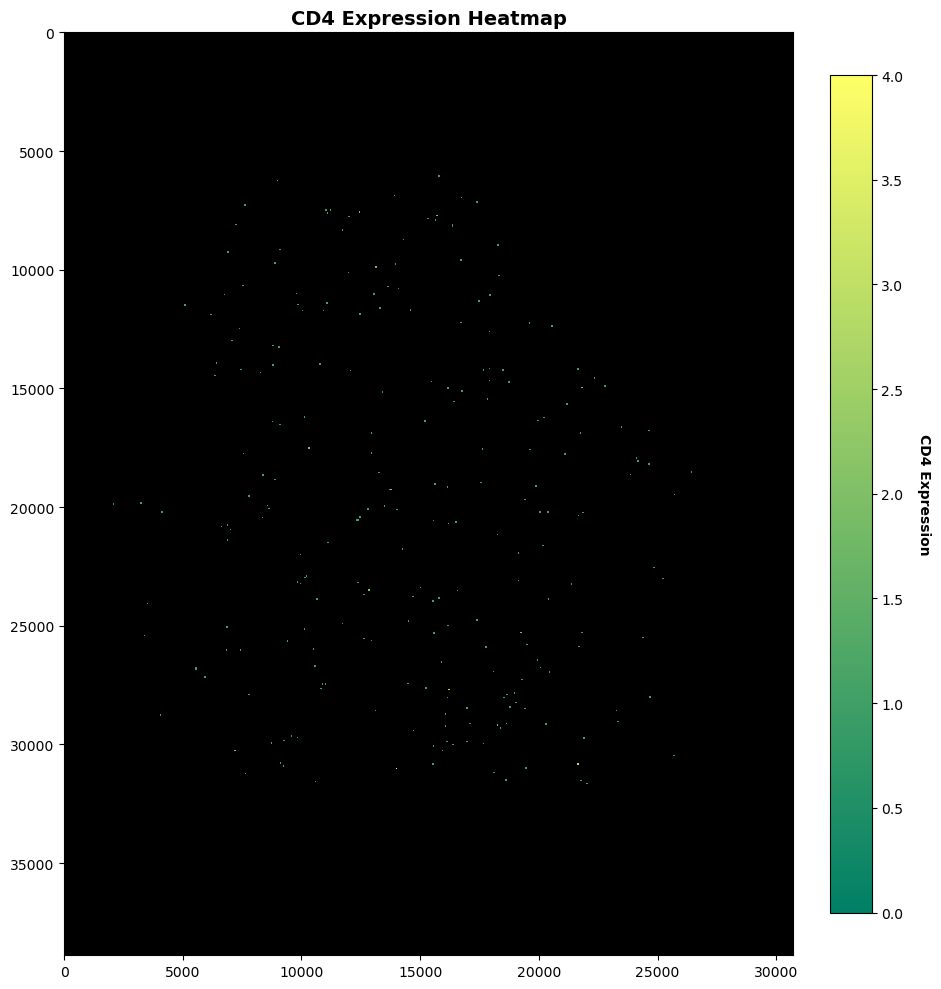

In [8]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np

# Get CD4 expression values
gene_idx = emb.var_names.get_loc('CD4')
expression_values = np.array(emb.X[:, gene_idx].todense()).flatten()

# Create colormap normalization
vmin = expression_values.min()
vmax = expression_values.max()
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.get_cmap('summer')  # You can change to 'plasma', 'inferno', 'magma', etc.

# Create figure
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(black_image)

# Plot spots with color representing expression
for i, (idx, row) in enumerate(emb.obs.iterrows()):
    expr_value = expression_values[i]
    if expr_value > 0:  # Only show spots with expression
        x = row['pxl_col_in_fullres']
        y = row['pxl_row_in_fullres']
        color = cmap(norm(expr_value))
        rect = plt.Rectangle((x+spot_dim/2, y+spot_dim/2), spot_dim, spot_dim, 
                            edgecolor='none', facecolor=color, alpha=1)
        ax.add_patch(rect)

# Add colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('CD4 Expression', rotation=270, labelpad=20, fontweight='bold')

plt.title("CD4 Expression Heatmap", fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

/tmp/ipykernel_132446/3424922840.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('summer')  # You can change to 'plasma', 'inferno', 'magma', etc.


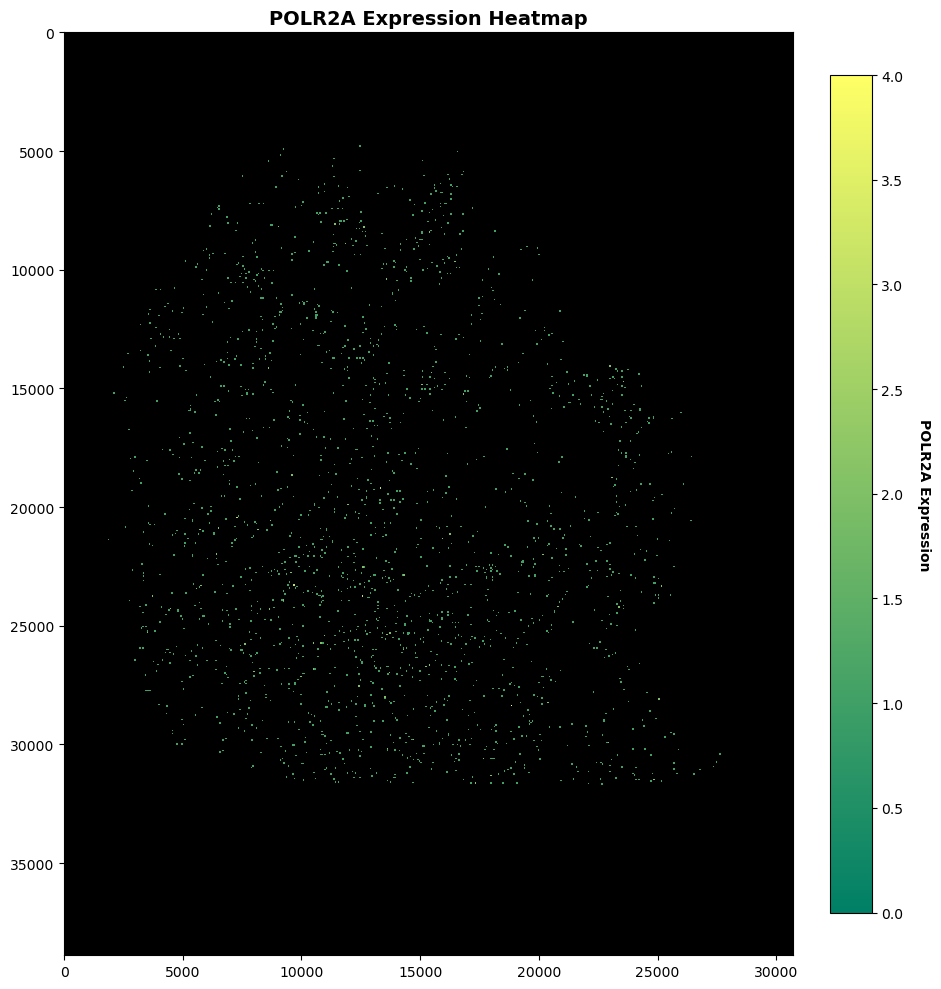

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np

# Get POLR2A expression values
gene_idx = emb.var_names.get_loc('POLR2A')
expression_values = np.array(emb.X[:, gene_idx].todense()).flatten()

# Create colormap normalization
vmin = expression_values.min()
vmax = expression_values.max()
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.get_cmap('summer')  # You can change to 'plasma', 'inferno', 'magma', etc.

# Create figure
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(black_image)

# Plot spots with color representing expression
for i, (idx, row) in enumerate(emb.obs.iterrows()):
    expr_value = expression_values[i]
    if expr_value > 0:  # Only show spots with expression
        x = row['pxl_col_in_fullres']
        y = row['pxl_row_in_fullres']
        color = cmap(norm(expr_value))
        rect = plt.Rectangle((x+spot_dim/2, y+spot_dim/2), spot_dim, spot_dim, 
                            edgecolor='none', facecolor=color, alpha=1)
        ax.add_patch(rect)

# Add colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('POLR2A Expression', rotation=270, labelpad=20, fontweight='bold')

plt.title("POLR2A Expression Heatmap", fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np

# Get SPP1 expression values
gene_idx = emb.var_names.get_loc('SPP1')
expression_values = np.array(emb.X[:, gene_idx].todense()).flatten()

# Create colormap normalization
vmin = expression_values.min()
vmax = expression_values.max()
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.get_cmap('summer')  # You can change to 'plasma', 'inferno', 'magma', etc.

# Create figure
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(black_image)

# Plot spots with color representing expression
for i, (idx, row) in enumerate(emb.obs.iterrows()):
    expr_value = expression_values[i]
    if expr_value > 0:  # Only show spots with expression
        x = row['pxl_col_in_fullres']
        y = row['pxl_row_in_fullres']
        color = cmap(norm(expr_value))
        rect = plt.Rectangle((x+spot_dim/2, y+spot_dim/2), spot_dim, spot_dim, 
                            edgecolor='none', facecolor=color, alpha=1)
        ax.add_patch(rect)

# Add colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('SPP1 Expression', rotation=270, labelpad=20, fontweight='bold')

plt.title("SPP1 Expression Heatmap", fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

/tmp/ipykernel_132446/2038320124.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('summer')  # You can change to 'plasma', 'inferno', 'magma', etc.


In [14]:
n_genes_per_spot = emb.obs["n_genes"].values

/tmp/ipykernel_3679506/1727414668.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('summer')  # You can change to 'plasma', 'inferno', 'magma', etc.


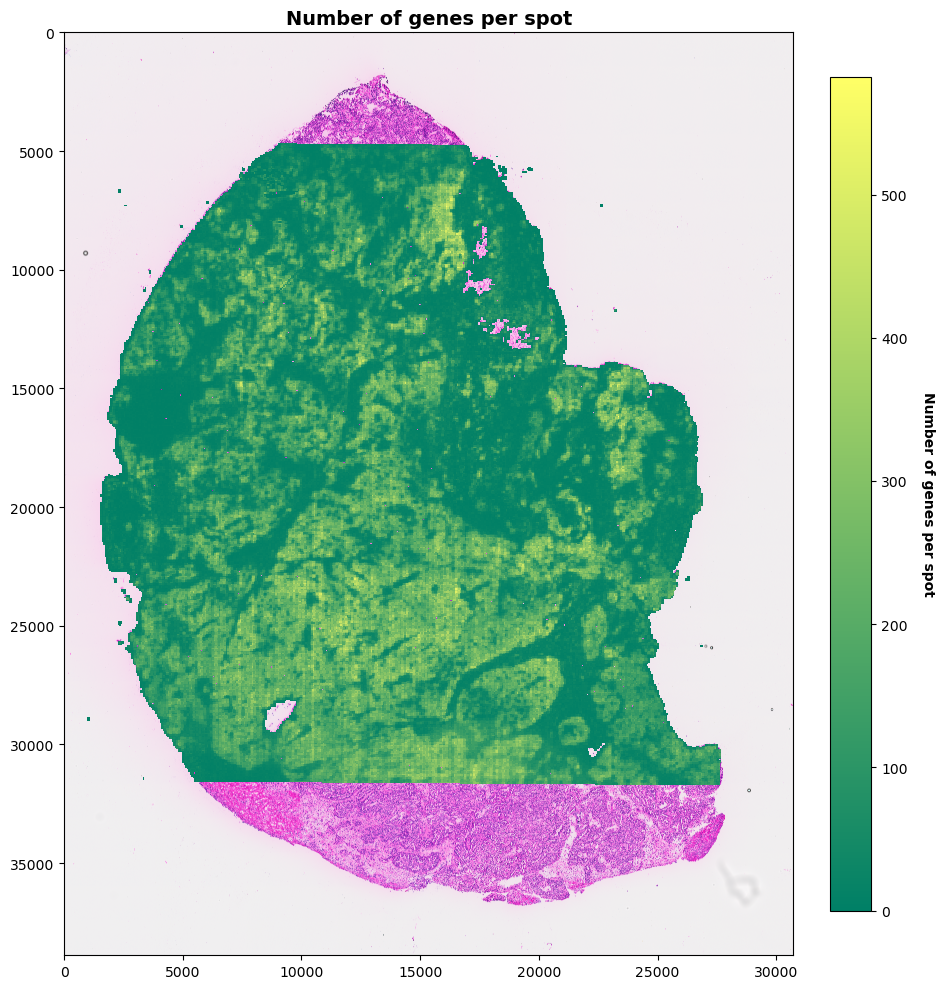

In [15]:

vmin = n_genes_per_spot.min()
vmax = n_genes_per_spot.max()
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.get_cmap('summer')  # You can change to 'plasma', 'inferno', 'magma', etc.

# Create figure
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(thumbnail)

# Plot spots with color representing expression
for i, (idx, row) in enumerate(emb.obs.iterrows()):
    expr_value = n_genes_per_spot[i]
    # if expr_value > 0:  # Only show spots with expression
    x = row['pxl_col_in_fullres']
    y = row['pxl_row_in_fullres']
    color = cmap(norm(expr_value))
    rect = plt.Rectangle((x+spot_dim/2, y+spot_dim/2), spot_dim, spot_dim, 
                        edgecolor='none', facecolor=color, alpha=1)
    ax.add_patch(rect)

# Add colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Number of genes per spot', rotation=270, labelpad=20, fontweight='bold')

plt.title("Number of genes per spot", fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

/tmp/ipykernel_3679506/1343448408.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('cool')  # You can change to 'plasma', 'inferno', 'magma', etc.


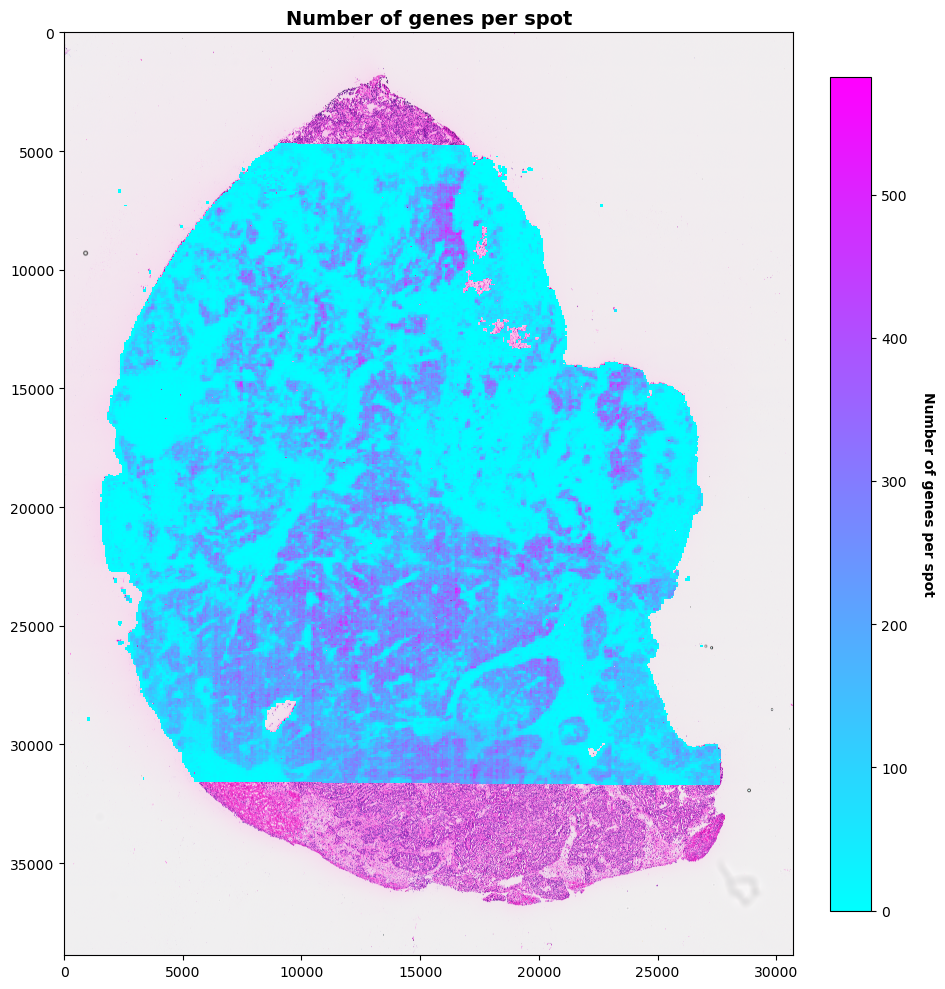

In [16]:

vmin = n_genes_per_spot.min()
vmax = n_genes_per_spot.max()
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.get_cmap('cool')  # You can change to 'plasma', 'inferno', 'magma', etc.

# Create figure
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(thumbnail)

# Plot spots with color representing expression
for i, (idx, row) in enumerate(emb.obs.iterrows()):
    expr_value = n_genes_per_spot[i]
    # if expr_value > 0:  # Only show spots with expression
    x = row['pxl_col_in_fullres']
    y = row['pxl_row_in_fullres']
    color = cmap(norm(expr_value))
    rect = plt.Rectangle((x+spot_dim/2, y+spot_dim/2), spot_dim, spot_dim, 
                        edgecolor='none', facecolor=color, alpha=1)
    ax.add_patch(rect)

# Add colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Number of genes per spot', rotation=270, labelpad=20, fontweight='bold')

plt.title("Number of genes per spot", fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()